In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import umap
import sys

sys.path.append("../")
from model import NNCLR

2023-04-04 13:45:15.458966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/z5214005/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-04 13:46:12.690484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Parameters
model_version = '3-31'
input_shape = (224, 224, 1)
temperature = 0.1
queue_size = 1000

batch_size = 16
stddev = 0.017359

In [4]:
# Load the saved model
model = NNCLR(input_shape=input_shape,
              temperature=temperature,
              queue_size=queue_size)

model.compile(
    contrastive_optimizer=keras.optimizers.Adam()
)

(model.load_weights(f'../checkpoint-{model_version}/checkpoint.ckpt')
      .expect_partial())

In [5]:
# Prepare the dataset
def preprocess(data):
    image = data['image']
    image = tf.clip_by_value(image, 0.0, 10.0)
    image = tf.math.asinh(image / stddev)
    return image

initial_dataset = tfds.load('hsc_icl', split='train')

# Dataset needs to be batched otherwise UMAP runs out of memory
dataset = initial_dataset.map(preprocess).batch(batch_size)

# Turn the dataset into a list so it can be indexed >:(
# (definitely inefficient but oh well)
ds_list = list(dataset.unbatch().as_numpy_iterator())

In [6]:
# # Get embeddings of the model on input data
# embeddings = model.predict(dataset,
#                            batch_size=batch_size)

In [7]:
# # Use UMAP to reduce to a 2D projection
# reducer = umap.UMAP(random_state=42) # random_state to remove randomness
# projection = reducer.fit_transform(embeddings)
# np.save('umap_projection.npy', projection)

# Load the UMAP projection if it's been saved already
projection = np.load('umap_projection.npy')

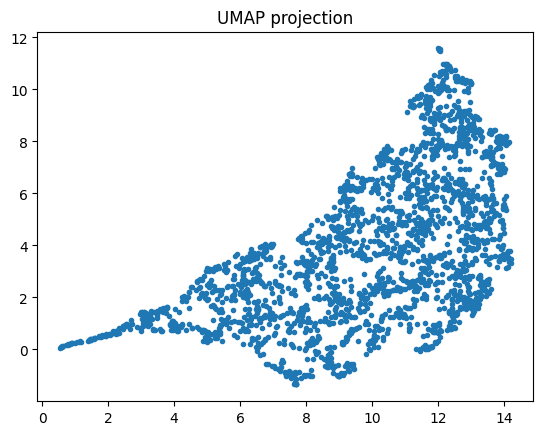

In [8]:
# Plot the projection
plt.scatter(projection[:,0], projection[:,1], marker='.')
plt.title('UMAP projection')
plt.show()

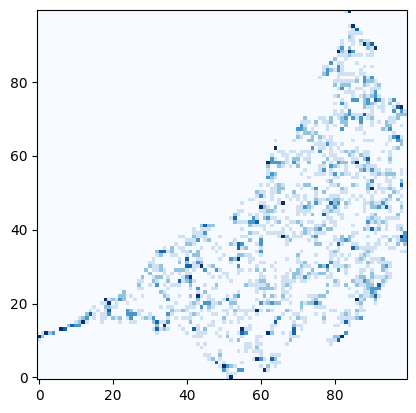

In [9]:
# Bin the data and use to extract some examples
hist, xedges, yedges, _ = plt.hist2d(
    projection[:,0], projection[:,1], bins=100, cmap='Blues'
)
plt.close()
# Use imshow so axes are labelled with rows and columns
plt.imshow(hist.T, origin='lower', cmap='Blues', interpolation='none', vmax=5)
plt.show()

In [10]:
# Extract some bins and corresponding bin edges
hist[0:8, 11:14] # This is a section that we want to look at

array([[6., 0., 0.],
       [2., 1., 0.],
       [0., 5., 0.],
       [0., 2., 0.],
       [0., 3., 0.],
       [0., 0., 0.],
       [0., 0., 8.],
       [0., 0., 4.]])

In [11]:
# Function to display the cutouts of selected boxes
def show_examples(min0, max0, min1, max1):
    """
    min0, max0 are slice bounds along axis 0
    min1, max1 are slice bounds along axis 1
    e.g. if you want to show examples from slice hist[0:8, 11:14] you can run
    show_examples(0,8,11,14)
    """
    # Get edges of required bins
    slice_xedges = xedges[min0:max0+1]
    slice_yedges = yedges[min1:max1+1]

    # Grab indices of corresponding cluster examples
    num_rows = len(slice_yedges) - 1
    num_cols = len(slice_xedges) - 1
    example_indices = -1 * np.ones((num_rows, num_cols), dtype=int)

    for row in range(num_rows):
        for col in range(num_cols):
            # Bin defines a bounding box that we want to get a cutout from
            ll = np.array([slice_xedges[col], slice_yedges[row]])
            ur = np.array([slice_xedges[col+1], slice_yedges[row+1]])
            # Find element within this bounding box, if it exists
            within_box = np.nonzero(np.all(
                np.logical_and(ll <= projection, projection <= ur),
                axis=1
            ))[0]
            if len(within_box) > 0:
                example_indices[row, col] = within_box[0]

    # Display the required cutouts pulled from the dataset organised in same
    # shape as histogram
    fig = plt.figure(figsize=(num_cols, num_rows), dpi=150)
    i = 1
    for row in range(num_rows-1, -1, -1): # Need to flip the rows
        for col in range(num_cols):
            ax = fig.add_subplot(num_rows, num_cols, i)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.setp(ax.spines.values(), color='white')
            i+=1
            if example_indices[row, col] == -1:
                continue
            else:
                # Display cutout on axis
                ax.imshow(ds_list[example_indices[row, col]], origin='lower')
    
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

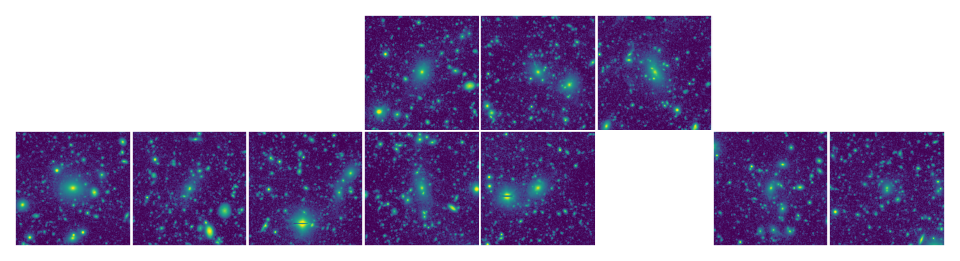

In [12]:
# show_examples(0, 8, 11, 14)
# show_examples(84, 85, 88, 100)
# show_examples(59, 61, 5, 10)
show_examples(72, 80, 40, 42)

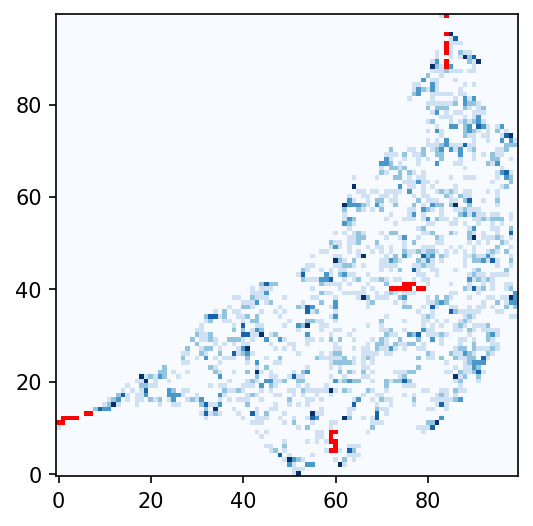

In [13]:
# Colour all the chosen sections on the UMAP histogram 
from matplotlib import cm
plt.figure(figsize=(5,4), dpi=150)

mask = np.zeros_like(hist)
mask[0:8, 11:14] = hist[0:8, 11:14]
mask[84:85, 88:100] = hist[84:85, 88:100]
mask[59:61, 5:10] = hist[59:61, 5:10]
mask[72:80, 40:42] = hist[72:80, 40:42]

hist_highlight = np.ma.array(hist, mask=mask)
cmap = cm.Blues
cmap.set_bad(color='red')
plt.imshow(hist_highlight.T, origin='lower', cmap=cmap, interpolation='none', vmax=5)
plt.show()

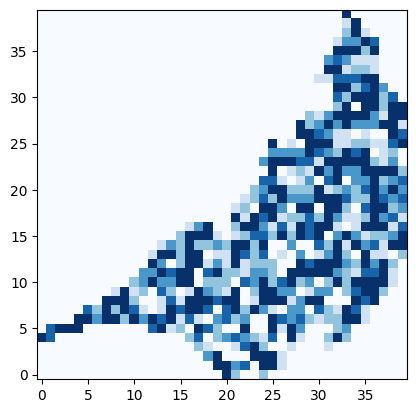

In [14]:
# Make a tiled version of UMAP
# Decrease number of bins
hist, xedges, yedges, _ = plt.hist2d(
    projection[:,0], projection[:,1], bins=40, cmap='Blues'
)
plt.close()
plt.imshow(hist.T, origin='lower', cmap='Blues', interpolation='none', vmax=5)
plt.show()

In [15]:
# Get an example from every non-zero bin and save the coordinates of that bin
x, y = np.where(hist > 0)
coords = list(zip(x, y)) # Coords of non-zero elements

images = []
for c in coords:
    # Get the lower left and upper right corners of the bin
    ll = np.array([xedges[c[0]], yedges[c[1]]])
    ur = np.array([xedges[c[0]+1], yedges[c[1]+1]])

    # Get an example cluster that falls inside this box
    idx = np.nonzero(np.all(
        np.logical_and(ll <= projection, projection <= ur),
        axis=1
    ))[0][0]

    images.append(ds_list[idx])

In [20]:
from PIL import Image

tile_size = 80
size = tile_size * len(hist)
output = Image.new('RGB', (size, size), (255,255,255)) # White background

# Draw tiles
for i, loc in enumerate(coords):
    # Convert to PIL image and resize
    img_norm = (images[i] / np.max(images[i])).squeeze()
    coloured = np.uint8(cm.viridis(img_norm) * 255) # using viridis colourmap
    img = Image.fromarray(coloured).convert('RGB')
    img = img.resize((tile_size, tile_size))

    # Calculate location of this tile and paste
    x, y = loc[0]*tile_size, loc[1]*tile_size
    y = size - y - tile_size # Flip the y axis to match the histogram

    output.paste(img, (x, y))

output.save('umap_tiled.png')